In [1]:
import logging
import warnings
import random
from typing import Dict, List, Tuple, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from sklearn.metrics import classification_report, roc_auc_score, brier_score_loss
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

In [2]:
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', 500)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
random.seed(hash("abc") % 2 ** 32 - 1)
np.random.seed(hash("xyz") % 2 ** 32 - 1)

In [3]:
class DatasetGenerator:
    """
    A class to generate a synthetic dataset for customer interactions and conversions.
    """

    def __init__(self, num_samples: int = 5000, seed: int = 42) -> None:
        """
        Initialize the DatasetGenerator.

        Args:
            num_samples (int): Number of samples to generate.
            seed (int): Random seed for reproducibility.
        """
        self.num_samples = num_samples
        self.seed = seed
        np.random.seed(self.seed)
        return None

    def generate_dataset(self) -> pd.DataFrame:
        """
        Generate the complete dataset by calling all feature generation methods
        and assembling the final dataframe.

        Returns:
            pd.DataFrame: The generated dataset.
        """
        customer_features = self._generate_customer_features()
        product_features = self._generate_product_features()
        interaction_details = self._generate_interaction_details()
        competitor_data = self._generate_competitor_data(
            product_features["sales_prices"]
        )
        conversion_data = self._generate_conversion_data(
            customer_features, interaction_details, competitor_data
        )

        data = self._assemble_dataframe(
            customer_features,
            product_features,
            interaction_details,
            competitor_data,
            conversion_data,
        )
        return data

    def _generate_customer_features(self) -> Dict[str, np.ndarray]:
        """
        Generate customer-related features including IDs, ages, genders, income levels,
        regions, and previous interactions.

        Returns:
            Dict[str, np.ndarray]: A dictionary containing customer feature arrays.
        """
        return {
            "customer_ids": np.arange(1, self.num_samples + 1),
            "ages": np.random.randint(18, 70, size=self.num_samples),
            "genders": np.random.choice(["Male", "Female"], size=self.num_samples),
            "income_levels": np.random.choice(
                ["Low", "Medium", "High"], size=self.num_samples, p=[0.3, 0.5, 0.2]
            ),
            "regions": np.random.choice(
                ["North", "South", "East", "West"], size=self.num_samples
            ),
            "previous_interactions": np.random.poisson(2, size=self.num_samples),
        }

    def _generate_product_features(self) -> Dict[str, np.ndarray]:
        """
        Generate product-related features including IDs, sales prices, purchase prices,
        and sales expenses.

        Returns:
            Dict[str, np.ndarray]: A dictionary containing product feature arrays.
        """
        sales_prices = np.random.uniform(20000, 50000, size=self.num_samples).round(-3)
        return {
            "product_ids": np.random.choice(
                ["Sedan", "SUV", "Truck", "Coupe"], size=self.num_samples
            ),
            "sales_prices": sales_prices,
            "purchase_prices": sales_prices
            * np.random.uniform(0.7, 0.9, size=self.num_samples),
            "sales_expenses": np.random.uniform(1000, 5000, size=self.num_samples),
        }

    def _generate_interaction_details(self) -> Dict[str, np.ndarray]:
        """
        Generate interaction-related features including response types, channels,
        response times, and preferred channels.

        Returns:
            Dict[str, np.ndarray]: A dictionary containing interaction detail arrays.
        """
        return {
            "response_types": np.random.choice(
                ["In_Person", "Substitute_Solution"],
                size=self.num_samples,
                p=[0.3, 0.7],
            ),
            "channels": np.random.choice(
                ["Online", "Phone", "In_Person"], size=self.num_samples
            ),
            "response_times": np.abs(np.random.normal(30, 10, size=self.num_samples)),
            "preferred_channel": np.random.choice(
                ["Online", "Phone", "In_Person"], size=self.num_samples
            ),
        }

    def _generate_competitor_data(
        self, sales_prices: np.ndarray
    ) -> Dict[str, np.ndarray]:
        """
        Generate competitor-related data including competitor prices and price differences.

        Args:
            sales_prices (np.ndarray): Array of sales prices to base competitor prices on.

        Returns:
            Dict[str, np.ndarray]: A dictionary containing competitor data arrays.
        """
        competitor_prices = sales_prices * np.random.uniform(
            0.95, 1.05, size=self.num_samples
        )
        return {
            "competitor_prices": competitor_prices,
            "price_differences": sales_prices - competitor_prices,
        }

    def _generate_conversion_data(
        self,
        customer_features: Dict[str, np.ndarray],
        interaction_details: Dict[str, np.ndarray],
        competitor_data: Dict[str, np.ndarray],
    ) -> Dict[str, np.ndarray]:
        """
        Generate conversion data based on customer features, interaction details, and competitor data.

        Args:
            customer_features (Dict[str, np.ndarray]): Dictionary of customer feature arrays.
            interaction_details (Dict[str, np.ndarray]): Dictionary of interaction detail arrays.
            competitor_data (Dict[str, np.ndarray]): Dictionary of competitor data arrays.

        Returns:
            Dict[str, np.ndarray]: A dictionary containing conversion data arrays.
        """
        base_prob = 0.05
        conversion_probs = np.full(self.num_samples, base_prob)

        conversion_probs += np.where(
            customer_features["income_levels"] == "High", 0.5, 0
        )
        conversion_probs += np.where(
            customer_features["income_levels"] == "Medium", 0.2, 0
        )
        conversion_probs += (
            np.clip(customer_features["previous_interactions"], 0, 5) * 0.1
        )

        conversion_probs += np.where(
            interaction_details["channels"] == interaction_details["preferred_channel"],
            0.2,
            0,
        )
        conversion_probs += np.where(
            interaction_details["response_types"] == "In_Person", 0.6, 0
        )

        price_diff_percent = (
            competitor_data["price_differences"] / competitor_data["competitor_prices"]
        )
        conversion_probs += np.where(price_diff_percent <= -0.05, -0.3, 0)

        conversion_probs = np.clip(conversion_probs, 0, 1)
        conversions = np.random.binomial(1, p=conversion_probs)

        return {"conversions": conversions, "conversion_probs": conversion_probs}

    def _assemble_dataframe(
        self,
        customer_features: dict,
        product_features: Dict[str, np.ndarray],
        interaction_details: Dict[str, np.ndarray],
        competitor_data: Dict[str, np.ndarray],
        conversion_data: Dict[str, np.ndarray],
    ) -> pd.DataFrame:
        """
        Assemble the final dataframe from all generated feature dictionaries.

        Args:
            customer_features (Dict[str, np.ndarray]): Dictionary of customer feature arrays.
            product_features (Dict[str, np.ndarray]): Dictionary of product feature arrays.
            interaction_details (Dict[str, np.ndarray]): Dictionary of interaction detail arrays.
            competitor_data (Dict[str, np.ndarray]): Dictionary of competitor data arrays.
            conversion_data (Dict[str, np.ndarray]): Dictionary of conversion data arrays.

        Returns:
            pd.DataFrame: The assembled dataframe containing all features.
        """
        data = pd.DataFrame(
            {
                "Customer_ID": customer_features["customer_ids"],
                "Age": customer_features["ages"],
                "Gender": customer_features["genders"],
                "Income_Level": customer_features["income_levels"],
                "Region": customer_features["regions"],
                "Previous_Interactions": customer_features["previous_interactions"],
                "Product_ID": product_features["product_ids"],
                "Sales_Price": product_features["sales_prices"],
                "Purchase_Price": product_features["purchase_prices"],
                "Sales_Expense": product_features["sales_expenses"],
                "Profit_Margin": product_features["sales_prices"]
                - product_features["purchase_prices"]
                - product_features["sales_expenses"],
                "Response_Type": interaction_details["response_types"],
                "Channel": interaction_details["channels"],
                "Response_Time": interaction_details["response_times"],
                "Conversion": conversion_data["conversions"],
                "Competitor_Price": competitor_data["competitor_prices"],
                "Price_Difference": competitor_data["price_differences"],
                "Preferred_Channel": interaction_details["preferred_channel"],
            }
        )

        data["Profit"] = data["Profit_Margin"] * data["Conversion"]
        data.to_csv("dataset.csv", index=False)
        return data

In [4]:
generator = DatasetGenerator(num_samples=5000, seed=42)
data = generator.generate_dataset()

In [5]:
class ConversionRateAnalyzer:
    """
    A class to analyze and visualize the conversion rates and profits.
    """

    def __init__(self, data: pd.DataFrame) -> None:
        """
        Initialize the ConversionRateAnalyzer with the dataset.

        Args:
            data (pd.DataFrame): The dataset to analyze.
        """
        self.data = data
        return None

    def analyze_conversion_rates(self) -> None:
        """
        Analyze and visualize conversion rates by Response Type.
        """
        conversion_rates = self.data.groupby("Response_Type")["Conversion"].mean()
        print("Conversion Rates by Response Type:")
        print(conversion_rates)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
        plt.title("Conversion Rates by Response Type")
        plt.ylabel("Conversion Rate")
        plt.show()
        return None

    def analyze_profit_by_response(self) -> None:
        """
        Analyze and visualize total profit by Response Type.
        """
        profit_by_response = self.data.groupby("Response_Type")["Profit"].sum()
        print("\nTotal Profit by Response Type:")
        print(profit_by_response)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=profit_by_response.index, y=profit_by_response.values)
        plt.title("Total Profit by Response Type")
        plt.ylabel("Total Profit")
        plt.show()
        return None

    def analyze_product_conversion_rates(self) -> None:
        """
        Analyze and visualize conversion rates by Response Type and Product ID.
        """
        product_conversion_rates = (
            self.data.groupby(["Response_Type", "Product_ID"])["Conversion"]
            .mean()
            .unstack()
        )
        print("\nConversion Rates by Response Type and Product ID:")
        print(product_conversion_rates)

        plt.figure(figsize=(12, 6))
        sns.heatmap(product_conversion_rates, annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title("Conversion Rates by Response Type and Product ID")
        plt.show()
        return None

    def analyze_income_conversion_rates(self) -> None:
        """
        Analyze and visualize conversion rates by Response Type and Income Level.
        """
        income_conversion_rates = (
            self.data.groupby(["Response_Type", "Income_Level"])["Conversion"]
            .mean()
            .unstack()
        )
        print("\nConversion Rates by Response Type and Income Level:")
        print(income_conversion_rates)

        plt.figure(figsize=(12, 6))
        sns.heatmap(income_conversion_rates, annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title("Conversion Rates by Response Type and Income Level")
        plt.show()
        return None

    def run_all(self) -> None:
        """
        Run all analysis methods in sequence.
        """
        self.analyze_conversion_rates()
        self.analyze_profit_by_response()
        self.analyze_product_conversion_rates()
        self.analyze_income_conversion_rates()
        return None

Conversion Rates by Response Type:
Response_Type
In_Person             0.94341
Substitute_Solution   0.50653
Name: Conversion, dtype: float64


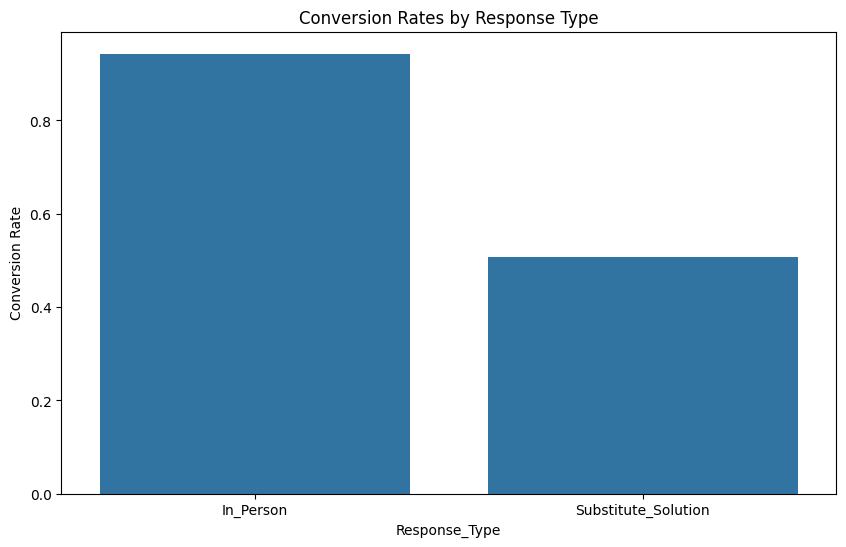


Total Profit by Response Type:
Response_Type
In_Person             5773886.76106
Substitute_Solution   7070663.78553
Name: Profit, dtype: float64


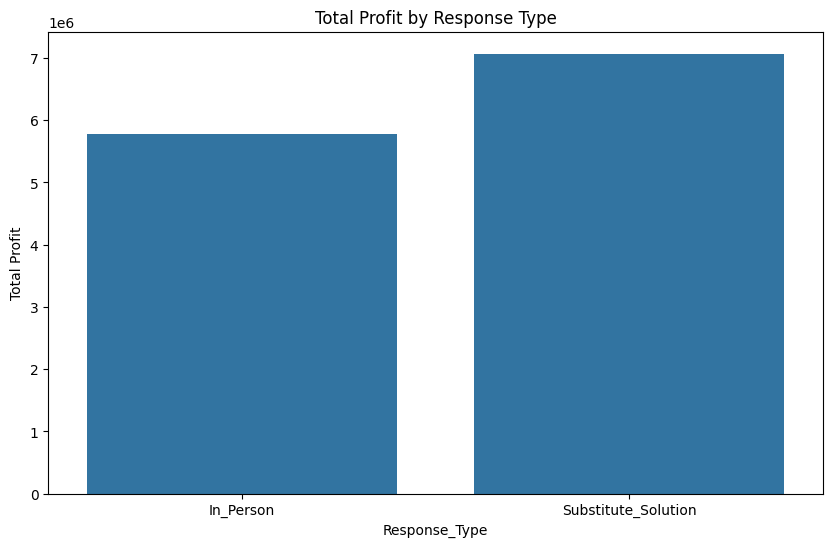


Conversion Rates by Response Type and Product ID:
Product_ID            Coupe     SUV   Sedan   Truck
Response_Type                                      
In_Person           0.95141 0.92978 0.95225 0.94118
Substitute_Solution 0.51934 0.46864 0.50308 0.53437


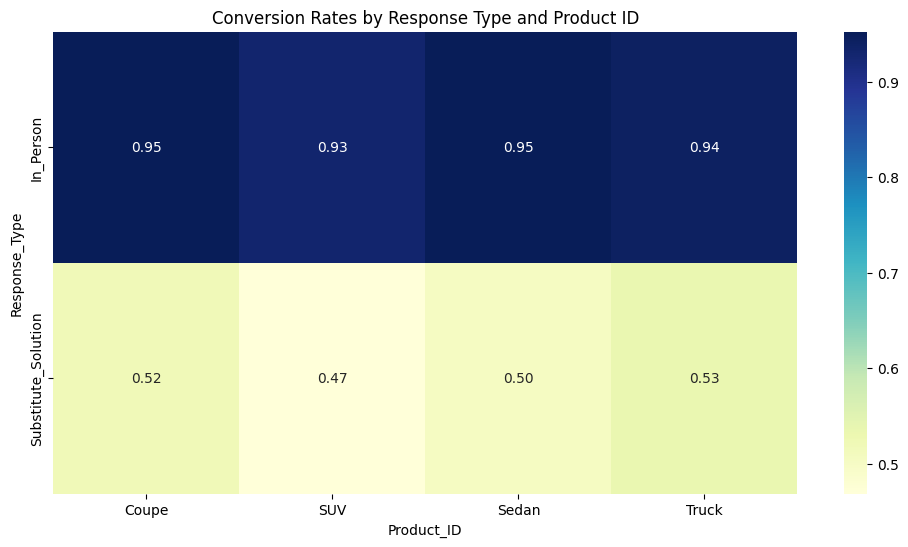


Conversion Rates by Response Type and Income Level:
Income_Level           High     Low  Medium
Response_Type                              
In_Person           1.00000 0.86994 0.96552
Substitute_Solution 0.80867 0.32764 0.49855


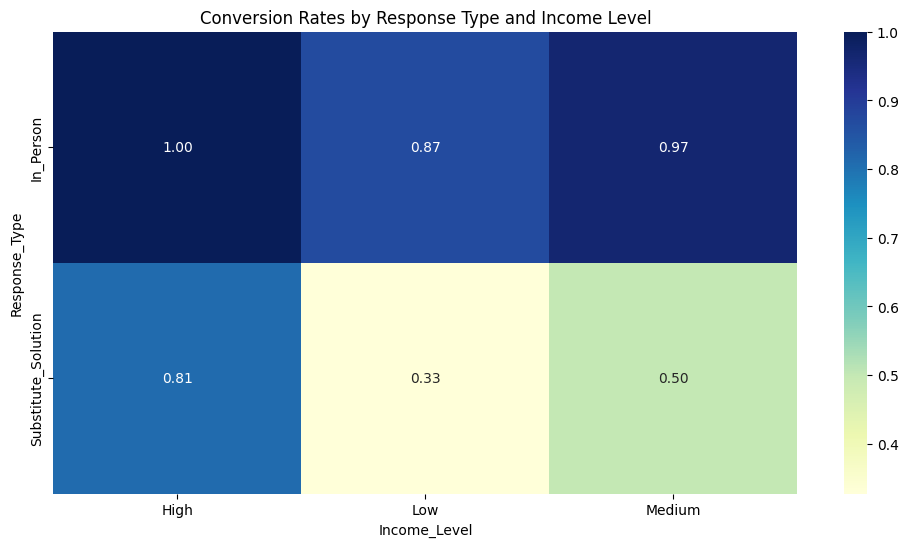

In [6]:
analyzer = ConversionRateAnalyzer(data)
analyzer.run_all()

In [7]:
class DataPreprocessor:
    """
    A class to preprocess the dataset.
    """

    def __init__(self, data: pd.DataFrame) -> None:
        """
        Initialize the DataPreprocessor with the dataset.

        Args:
            data (pd.DataFrame): The dataset to preprocess.
        """
        self.data = data
        self.features = [
            "Age",
            "Gender",
            "Income_Level",
            "Region",
            "Previous_Interactions",
            "Product_ID",
            "Sales_Price",
            "Response_Time",
            "Channel",
            "Price_Difference",
            "Competitor_Price",
        ]
        self.categorical_features = [
            "Gender",
            "Income_Level",
            "Region",
            "Product_ID",
            "Channel",
            "Preferred_Channel",
            "Response_Type",
        ]
        self.numerical_features = [
            "Age",
            "Previous_Interactions",
            "Sales_Price",
            "Response_Time",
            "Price_Difference",
        ]
        return None

    def encode_categorical_features(self) -> pd.DataFrame:
        """
        Encode categorical features using one-hot encoding.

        Returns:
            pd.DataFrame: The dataset with encoded categorical features.
        """
        return pd.get_dummies(
            self.data, columns=self.categorical_features, drop_first=True
        )

    def get_feature_columns(self, data_encoded: pd.DataFrame) -> List[str]:
        """
        Get the list of feature columns, including dummy variables.

        Args:
            data_encoded (pd.DataFrame): The encoded dataset.

        Returns:
            List[str]: List of feature column names.
        """
        dummy_columns = [
            col
            for col in data_encoded.columns
            if any(cat in col for cat in self.categorical_features)
        ]
        return self.numerical_features + dummy_columns

    def prepare_data(self) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Prepare the data for machine learning by encoding categorical features
        and selecting relevant columns.

        Returns:
            Tuple[pd.DataFrame, pd.Series]: Features (X) and target variable (y).
        """
        data_encoded = self.encode_categorical_features()
        feature_columns = self.get_feature_columns(data_encoded)
        X = data_encoded[feature_columns]
        y = data_encoded["Conversion"]
        return X, y

    def split_data(
        self, test_size: float = 0.3, random_state: int = 42
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
        """
        Split the data into training and testing sets.

        Args:
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Random state for reproducibility.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]: X_train, X_test, y_train, y_test
        """
        X, y = self.prepare_data()
        return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [8]:
preprocessor = DataPreprocessor(data)
X_train, X_test, y_train, y_test = preprocessor.split_data()

In [9]:
class ModelTrainer:
    """
    A class to train and evaluate multiple classification models.
    """

    def __init__(
        self,
        X_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_train: pd.Series,
        y_test: pd.Series,
    ) -> None:
        """
        Initialize the ModelTrainer with training and testing data.

        Args:
            X_train (pd.DataFrame): Training features
            X_test (pd.DataFrame): Testing features
            y_train (pd.Series): Training labels
            y_test (pd.Series): Testing labels
        """
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.models = {}
        self.results = {}
        return None

    def train_models(self, random_state: int = 42) -> None:
        """
        Train RandomForestClassifier, GradientBoostingClassifier, and XGBoostClassifier models.

        Args:
            random_state (int): Random state for reproducibility
        """
        self.models = {
            "RandomForest": RandomForestClassifier(random_state=random_state),
            "GradientBoosting": GradientBoostingClassifier(random_state=random_state),
            "XGBoost": XGBClassifier(
                random_state=random_state,
                use_label_encoder=False,
                eval_metric="logloss",
            ),
        }

        for name, model in self.models.items():
            model.fit(self.X_train, self.y_train)
            self.results[name] = self._evaluate_model(model)
        return None

    def _evaluate_model(self, model: BaseEstimator) -> Dict[str, Any]:
        """
        Evaluate a trained model and return performance metrics.

        Args:
            model (BaseEstimator): Trained sklearn-compatible model

        Returns:
            Dict[str, Any]: Dictionary containing evaluation metrics
        """
        y_pred = model.predict(self.X_test)
        y_pred_proba = model.predict_proba(self.X_test)[:, 1]

        return {
            "classification_report": classification_report(self.y_test, y_pred),
            "roc_auc_score": roc_auc_score(self.y_test, y_pred_proba),
            "y_pred": y_pred,
            "y_pred_proba": y_pred_proba,
        }

    def print_results(self):
        """
        Print classification report and ROC AUC score for each model.
        """
        for name, result in self.results.items():
            print(f"\n--- {name} Results ---")
            print(result["classification_report"])
            print(f"ROC AUC Score: {result['roc_auc_score']:.4f}")

    def plot_calibration_curves(self):
        """
        Plot calibration curves for all trained models.
        """
        plt.figure(figsize=(12, 8))
        for name, model in self.models.items():
            CalibrationDisplay.from_estimator(
                model, self.X_test, self.y_test, n_bins=10, name=name
            )
        plt.title("Calibration Curves")
        plt.legend()
        plt.show()

    def plot_lift_curves(self):
        """
        Plot lift curves for all trained models.
        """
        plt.figure(figsize=(12, 8))
        for name, result in self.results.items():
            self._plot_single_lift_curve(self.y_test, result["y_pred_proba"], name)
        plt.title("Lift Curves")
        plt.legend()
        plt.show()

    @staticmethod
    def _plot_single_lift_curve(
        y_true: np.ndarray, y_scores: np.ndarray, model_name: str
    ):
        """
        Plot a lift curve for a single model.

        Args:
            y_true (np.ndarray): True labels
            y_scores (np.ndarray): Predicted probabilities
            model_name (str): Name of the model for the legend
        """
        data = pd.DataFrame({"y_true": y_true, "y_scores": y_scores})
        data.sort_values("y_scores", ascending=False, inplace=True)

        data["cum_true"] = data["y_true"].cumsum()
        data["lift"] = data["cum_true"] / data["y_true"].sum()
        data["baseline"] = np.arange(1, len(data) + 1) / len(data)

        plt.plot(data["lift"].values, label=f"{model_name} Lift Curve")
        plt.plot(data["baseline"].values, label="Baseline", linestyle="--")
        plt.xlabel("Percentage of Sample")
        plt.ylabel("Percentage of Positive Outcomes")

    def get_best_model(self, metric: str = "roc_auc_score") -> str:
        """
        Get the name of the best performing model based on a specified metric.

        Args:
            metric (str): Metric to use for comparison (default is 'roc_auc_score')

        Returns:
            str: Name of the best performing model
        """
        return max(self.results, key=lambda x: self.results[x][metric])


--- RandomForest Results ---
              precision    recall  f1-score   support

           0       0.68      0.60      0.63       560
           1       0.78      0.83      0.80       940

    accuracy                           0.74      1500
   macro avg       0.73      0.71      0.72      1500
weighted avg       0.74      0.74      0.74      1500

ROC AUC Score: 0.8200

--- GradientBoosting Results ---
              precision    recall  f1-score   support

           0       0.69      0.62      0.66       560
           1       0.79      0.84      0.81       940

    accuracy                           0.76      1500
   macro avg       0.74      0.73      0.73      1500
weighted avg       0.75      0.76      0.75      1500

ROC AUC Score: 0.8281

--- XGBoost Results ---
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       560
           1       0.77      0.80      0.78       940

    accuracy                           0.72      

<Figure size 1200x800 with 0 Axes>

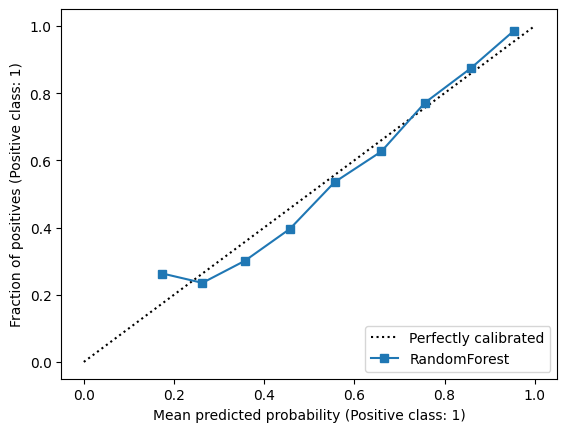

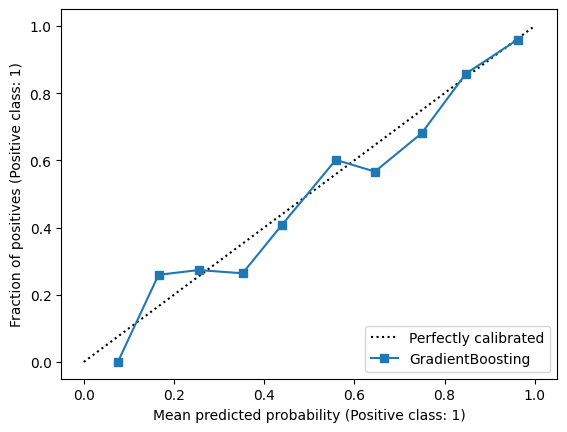

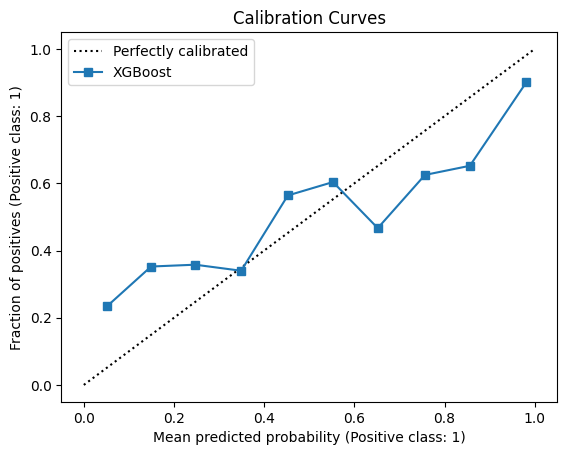

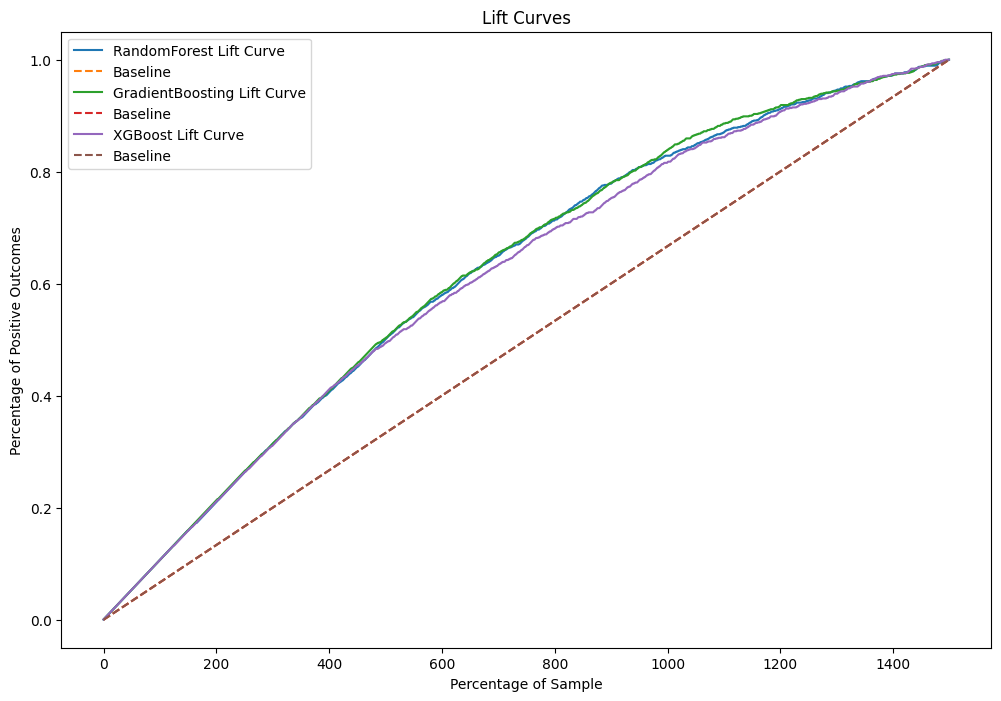


Best performing model: GradientBoosting


In [10]:
trainer = ModelTrainer(X_train, X_test, y_train, y_test)
trainer.train_models()
trainer.print_results()
trainer.plot_calibration_curves()
trainer.plot_lift_curves()

best_model = trainer.get_best_model()
print(f"\nBest performing model: {best_model}")

In [11]:
class ModelCalibrationTrainer:
    """
    A class to train, calibrate, and evaluate models with a focus on profit optimization.
    """

    def __init__(
        self,
        X_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_train: pd.Series,
        y_test: pd.Series,
        profit_margins: pd.Series,
    ) -> None:
        """
        Initialize the ModelCalibrationTrainer with training and testing data.

        Args:
            X_train (pd.DataFrame): Training features
            X_test (pd.DataFrame): Testing features
            y_train (pd.Series): Training labels
            y_test (pd.Series): Testing labels
            profit_margins (pd.Series): Profit margins for each sample
        """
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.profit_margins = profit_margins
        self.models = {}
        self.calibrated_models = {}
        self.results = {}
        return None

    def train_models(self, random_state: int = 42) -> None:
        """
        Train RandomForestClassifier, GradientBoostingClassifier, and XGBClassifier models.

        Args:
            random_state (int): Random state for reproducibility
        """
        self.models = {
            "RandomForest": RandomForestClassifier(random_state=random_state),
            "GradientBoosting": GradientBoostingClassifier(random_state=random_state),
            "XGBoost": XGBClassifier(
                random_state=random_state,
                use_label_encoder=False,
                eval_metric="logloss",
            ),
        }

        for name, model in self.models.items():
            model.fit(self.X_train, self.y_train)
        return None

    def calibrate_models(self, cv: int = 5) -> None:
        """
        Calibrate all trained models using CalibratedClassifierCV.

        Args:
            cv (int): Number of cross-validation folds for calibration
        """
        for name, model in self.models.items():
            calibrated_model = CalibratedClassifierCV(model, cv=cv, method="isotonic")
            calibrated_model.fit(self.X_train, self.y_train)
            self.calibrated_models[name] = calibrated_model
            self.results[name] = self._evaluate_model(calibrated_model)

    def _evaluate_model(self, model: BaseEstimator) -> Dict[str, Any]:
        """
        Evaluate a calibrated model and return performance metrics.

        Args:
            model (BaseEstimator): Calibrated model

        Returns:
            Dict[str, Any]: Dictionary containing evaluation metrics
        """
        y_pred = model.predict(self.X_test)
        y_pred_proba = model.predict_proba(self.X_test)[:, 1]
        expected_profit = y_pred_proba * self.profit_margins

        return {
            "classification_report": classification_report(self.y_test, y_pred),
            "roc_auc_score": roc_auc_score(self.y_test, y_pred_proba),
            "brier_score": brier_score_loss(self.y_test, y_pred_proba),
            "expected_profit": expected_profit.sum(),
            "y_pred": y_pred,
            "y_pred_proba": y_pred_proba,
        }

    def print_results(self) -> None:
        """
        Print results for calibrated models.
        """
        for name, result in self.results.items():
            print(f"\n--- Calibrated {name} Results ---")
            print(result["classification_report"])
            print(f"ROC AUC Score: {result['roc_auc_score']:.4f}")
            print(f"Brier Score: {result['brier_score']:.4f}")
            print(f"Expected Profit: ${result['expected_profit']:.2f}")

    def plot_lift_curves(self):
        """
        Plot lift curves for all trained models.
        """
        plt.figure(figsize=(12, 8))
        for name, result in self.results.items():
            self._plot_single_lift_curve(self.y_test, result["y_pred_proba"], name)
        plt.title("Lift Curves")
        plt.legend()
        plt.show()

    @staticmethod
    def _plot_single_lift_curve(
        y_true: np.ndarray, y_scores: np.ndarray, model_name: str
    ):
        """
        Plot a lift curve for a single model.

        Args:
            y_true (np.ndarray): True labels
            y_scores (np.ndarray): Predicted probabilities
            model_name (str): Name of the model for the legend
        """
        data = pd.DataFrame({"y_true": y_true, "y_scores": y_scores})
        data.sort_values("y_scores", ascending=False, inplace=True)

        data["cum_true"] = data["y_true"].cumsum()
        data["lift"] = data["cum_true"] / data["y_true"].sum()
        data["baseline"] = np.arange(1, len(data) + 1) / len(data)

        plt.plot(data["lift"].values, label=f"{model_name} Lift Curve")
        plt.plot(data["baseline"].values, label="Baseline", linestyle="--")
        plt.xlabel("Percentage of Sample")
        plt.ylabel("Percentage of Positive Outcomes")

    def plot_calibration_curves(self) -> None:
        """
        Plot calibration curves for all calibrated models.
        """
        plt.figure(figsize=(12, 8))
        for name, model in self.calibrated_models.items():
            CalibrationDisplay.from_estimator(
                model, self.X_test, self.y_test, n_bins=10, name=f"Calibrated {name}"
            )
        plt.title("Calibration Curves")
        plt.legend()
        plt.show()

    def plot_profit_curves(self) -> None:
        """
        Plot profit curves for all calibrated models.
        """
        plt.figure(figsize=(12, 8))
        for name, result in self.results.items():
            self._plot_single_profit_curve(
                self.y_test, result["y_pred_proba"], self.profit_margins, name
            )
        plt.title("Profit Curves")
        plt.legend()
        plt.grid(True)
        plt.show()
        return None

    @staticmethod
    def _plot_single_profit_curve(
        y_true: np.ndarray,
        y_scores: np.ndarray,
        profit_margins: np.ndarray,
        model_name: str,
    ) -> None:
        """
        Plot a profit curve for a single model.

        Args:
            y_true (np.ndarray): True labels
            y_scores (np.ndarray): Predicted probabilities
            profit_margins (np.ndarray): Profit margins for each sample
            model_name (str): Name of the model for the legend
        """
        data = pd.DataFrame(
            {"y_true": y_true, "y_scores": y_scores, "profit_margin": profit_margins}
        )
        data.sort_values("y_scores", ascending=False, inplace=True)

        data["cum_profit"] = (data["y_true"] * data["profit_margin"]).cumsum()
        data["percentage"] = np.arange(1, len(data) + 1) / len(data)
        total_possible_profit = (data["y_true"] * data["profit_margin"]).sum()

        plt.plot(
            data["percentage"],
            data["cum_profit"] / total_possible_profit,
            label=f"{model_name} Profit Curve",
        )

        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Baseline")

        plt.xlabel("Percentage of Sample")
        plt.ylabel("Percentage of Total Possible Profit")
        plt.title("Cumulative Profit Curve")
        return None

    def get_best_model(self, metric: str = "expected_profit") -> str:
        """
        Get the name of the best performing calibrated model based on a specified metric.

        Args:
            metric (str): Metric to use for comparison (default is 'expected_profit')

        Returns:
            str: Name of the best performing calibrated model
        """
        return max(self.results, key=lambda x: self.results[x][metric])

    def run_all(self) -> None:
        """
        Run all steps: train models, calibrate models, print results, and plot curves.
        """
        self.train_models()
        self.calibrate_models()
        self.print_results()
        self.plot_calibration_curves()
        self.plot_lift_curves()
        self.plot_profit_curves()
        best_model = self.get_best_model()
        print(f"\nBest calibrated model based on expected profit: {best_model}")
        return None


--- Calibrated RandomForest Results ---
              precision    recall  f1-score   support

           0       0.67      0.62      0.64       560
           1       0.78      0.82      0.80       940

    accuracy                           0.74      1500
   macro avg       0.73      0.72      0.72      1500
weighted avg       0.74      0.74      0.74      1500

ROC AUC Score: 0.8200
Brier Score: 0.1662
Expected Profit: $3777730.33

--- Calibrated GradientBoosting Results ---
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       560
           1       0.79      0.83      0.81       940

    accuracy                           0.76      1500
   macro avg       0.74      0.73      0.74      1500
weighted avg       0.76      0.76      0.76      1500

ROC AUC Score: 0.8299
Brier Score: 0.1622
Expected Profit: $3785833.71

--- Calibrated XGBoost Results ---
              precision    recall  f1-score   support

           0       0.67    

<Figure size 1200x800 with 0 Axes>

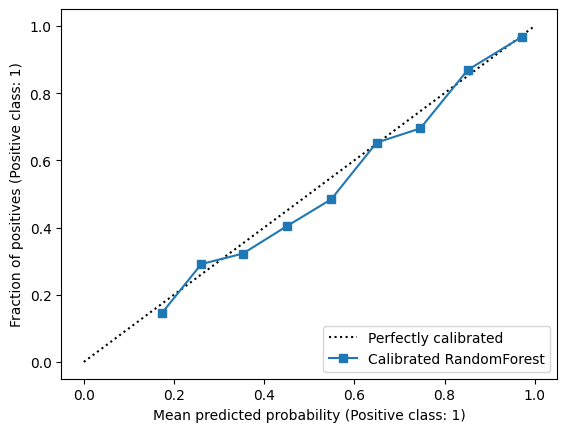

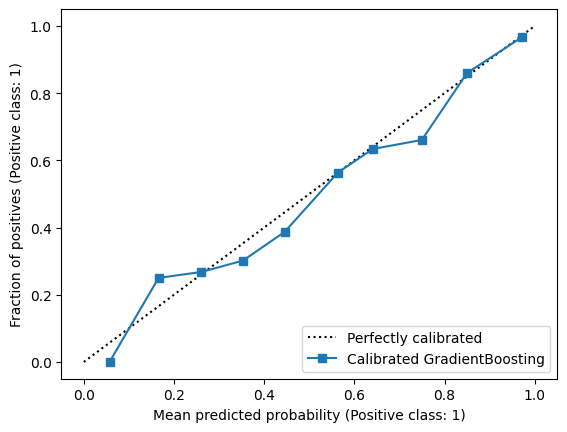

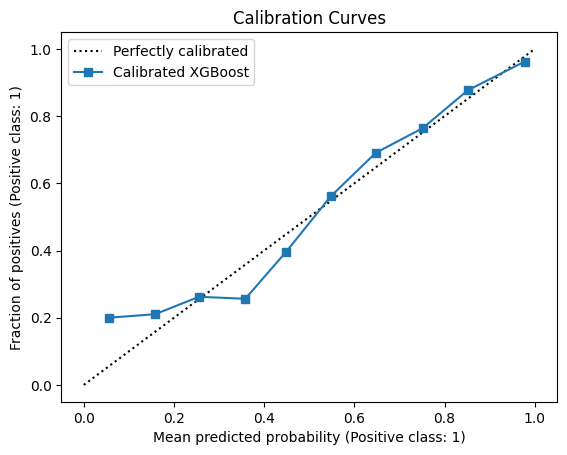

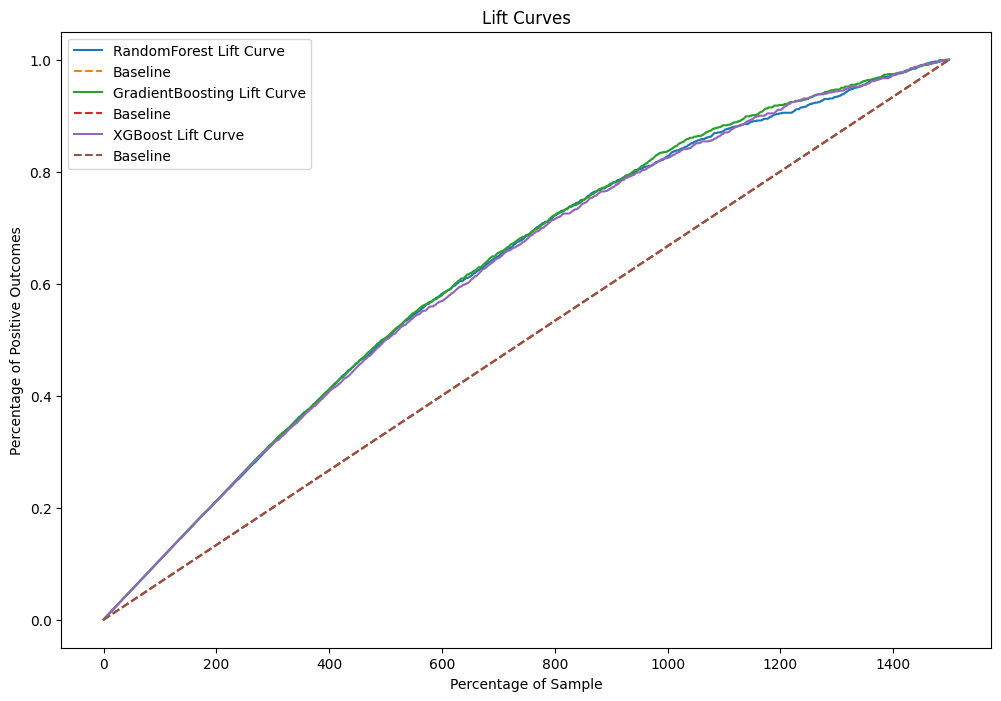

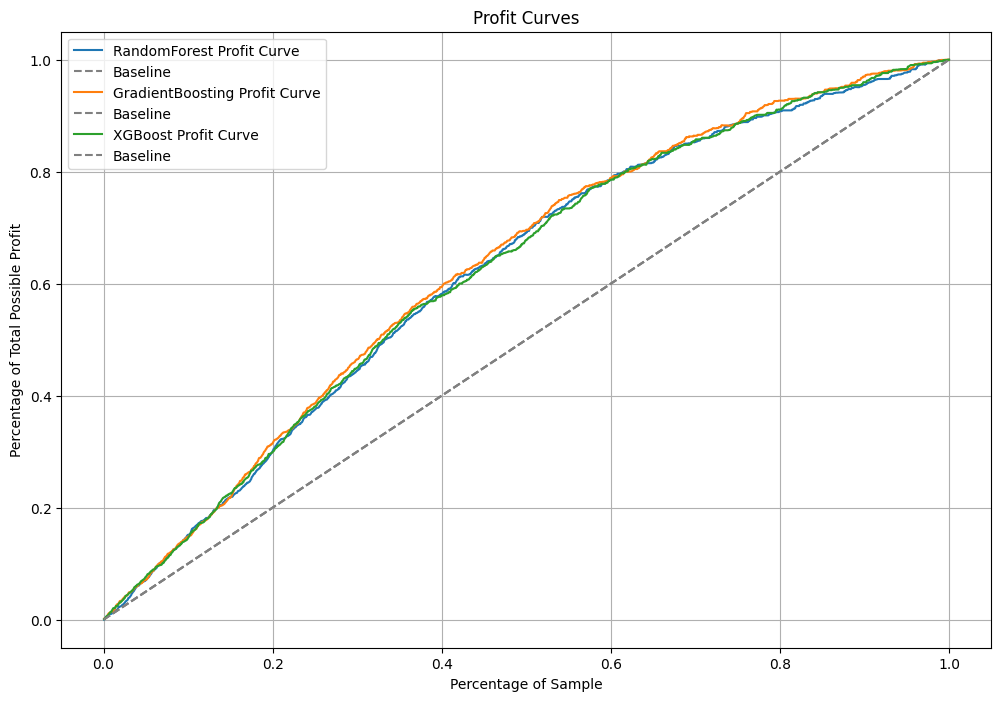


Best calibrated model based on expected profit: GradientBoosting


In [12]:
profit_margins_test = data.loc[X_test.index, "Profit_Margin"]
calibration_trainer = ModelCalibrationTrainer(X_train, X_test, y_train, y_test, profit_margins_test)
calibration_trainer.run_all()